In [2]:
!git pull

Already up to date.


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from core.imports import *

/usr/local/lib/python3.6/dist-packages/OpenSSL/crypto.py:8: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography import utils, x509


In [5]:
import torch
from torch import nn

device = 'cuda'
batch_size = 64

from sku import AttributeEmbedding, FrozenEmbedder

path = fs.join(ETL_PATH, job_name, 'SIGIR-ecom-data-challenge/train')
fname = fs.join(path, 'sku_embeddings.pkl')

In [6]:
from model import MultiTaskLanguageModel

model = MultiTaskLanguageModel(fname, device, batch_size=batch_size, small_data=True)
model;

In [23]:
model = MultiTaskLanguageModel.load_from_checkpoint('logs/full_model_1/default/version_8/checkpoints/epoch=53-step=5669.ckpt')

In [7]:
from pytorch_lightning.loggers import CSVLogger

from core.models.mlp import LitProgressBar
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import TQDMProgressBar, EarlyStopping, ProgressBarBase

logger = CSVLogger('logs/test')
print(logger.log_dir)
trainer = Trainer(
    gpus=1,
    max_epochs=10,
    callbacks=[LitProgressBar()],#, EarlyStopping(monitor="val_loss", mode="min", patience=10)],
    logger=logger,
    enable_checkpointing=False,
    log_every_n_steps=10,
#     track_grad_norm=2,
#     auto_scale_batch_size='binsearch',
#     auto_lr_find=True
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


logs/test/default/version_12


In [9]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/trainer/optimizers.py:227: RuntimeWarning: Found unsupported keys in the optimizer configuration: {'interval', 'scheduler'}
  rank_zero_warn(f"Found unsupported keys in the optimizer configuration: {set(extra_keys)}", RuntimeWarning)

  | Name         | Type       | Params
--------------------------------------------
0 | item_adapter | Sequential | 13.6 K
1 | rnn          | GRU        | 79.7 K
2 | heads        | ModuleDict | 121 K 
--------------------------------------------
214 K     Trainable params
0         Non-trainable params
214 K     Total params
0.857     Total estimated model params size (MB)


2022-08-26 18:23:24 Starting validation
2022-08-26 18:23:25 Validation time 1.14s
2022-08-26 18:23:25 pid 31317 | starting to iterate train, updating every 1 seconds
2022-08-26 18:23:27 Starting validation
2022-08-26 18:23:28 Validation time 1.69s
2022-08-26 18:23:28 pid 31317 | 2 of 10, 20.0% of train, speed: 1.73 s/it, elapsed 3.47 seconds, tr_loss: 8.5737, val_loss: 7.5912
2022-08-26 18:23:30 Starting validation
2022-08-26 18:23:32 Validation time 1.64s
2022-08-26 18:23:32 pid 31317 | 3 of 10, 30.0% of train, speed: 2.29 s/it, elapsed 6.87 seconds, tr_loss: 5.5468, val_loss: 5.0896
2022-08-26 18:23:34 Starting validation
2022-08-26 18:23:35 Validation time 1.67s
2022-08-26 18:23:35 pid 31317 | print interval is now 5s
2022-08-26 18:23:35 pid 31317 | 4 of 10, 40.0% of train, speed: 2.62 s/it, elapsed 10.48 seconds, tr_loss: 4.4190, val_loss: 4.0301
2022-08-26 18:23:37 Starting validation
2022-08-26 18:23:39 Validation time 1.77s
2022-08-26 18:23:41 Starting validation
2022-08-26 18:2

In [ ]:
trainer.

In [20]:
dl = model.val_dataloader()

In [21]:
for lengths, sessions, tasks, masks in dl: 1/0


ZeroDivisionError: division by zero

In [ ]:
model.

In [27]:
model.sku_embedder.to('cpu')

In [28]:
output, head_activations = model(sessions.to('cpu'), lengths.to('cpu'))

In [60]:
true_prices = model.sku_embedder.attr_embs.emb('price', tasks['next_sku'])[masks['next_sku']].to('cpu')#.numpy()

In [62]:
true_prices.view(-1)

tensor([9., 8., 6.,  ..., 7., 7., 7.])

In [41]:
pred_prices = head_activations['next_sku_price'][masks['next_sku']].detach().cpu().numpy()

In [47]:
d = defaultdict(list)
for tp, pp in zip(true_prices, pred_prices):
    d[float(tp)].append(float(pp))

In [58]:
(pred_prices.squeeze().round() == true_prices.squeeze()).sum()

21203

In [59]:
len(pred_prices.squeeze())

33112

<AxesSubplot:>

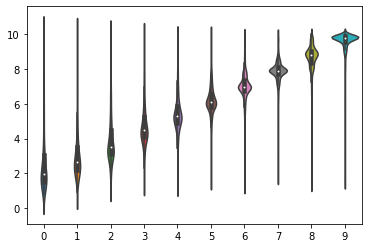

In [52]:
import seaborn as sns
sns.violinplot(data=[d[i] for i in range(1,11)])

In [474]:
acum = index.prec_at_k_accumulator(20)

In [475]:
pred = head_activations['purch_sku_descr'].detach()[masks['purch_sku']]
target = attr_emb.emb('descr', tasks['purch_sku'])[masks['purch_sku']]

acum.add_stats(pred, target)

In [483]:
!git pull

remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 7 (delta 6), reused 7 (delta 6), pack-reused 0
Unpacking objects: 100% (7/7), done.
From https://github.com/mercadolibre/fury_user-navigation-research
   f34b684..2a4918e  experiment-design -> origin/experiment-design
Updating f34b684..2a4918e
Fast-forward
 experiments/SIGIR/emb_classification_metrics.py | 12 ++++-
 experiments/SIGIR/model.py                      | 59 ++++++++++++++++---------
 experiments/SIGIR/sku.py                        | 11 ++++-
 3 files changed, 57 insertions(+), 25 deletions(-)


In [476]:
acum.prec

array([0.17836257, 0.2251462 , 0.24853801, 0.26608187, 0.27777778,
       0.30116959, 0.3128655 , 0.33625731, 0.33918129, 0.34210526,
       0.35087719, 0.38304094, 0.4005848 , 0.40643275, 0.40935673,
       0.42397661, 0.42982456, 0.43859649, 0.44152047, 0.44736842])

In [468]:
sessions.device.type

'cpu'

In [466]:
purch_sku_descr_pred = head_activations['purch_sku_descr'].detach()
purch_sku_descr_pred = purch_sku_descr_pred[masks['purch_sku']]

purch_sku_descr_pred = purch_sku_descr_pred / torch.norm(purch_sku_descr_pred, p=2, dim=1)[:, None]

target = attr_emb.emb('descr', tasks['purch_sku'])[masks['purch_sku']].cpu().numpy().copy()
target_normed = target / np.linalg.norm(target, axis=1)[:, None]

target_indices = torch.tensor(index.get_ids(target))

top_indices = torch.topk(purch_sku_descr_pred @ index.vectors_normed.t(), k=20, dim=1).indices

n = 0
for i in range(20):
    n += (top_indices[:, i] == target_indices).sum()
n / len(target_indices)

In [294]:
sessions.shape

torch.Size([64, 32])

In [295]:
masks['purch_sku'].shape

torch.Size([64, 32])

In [296]:
purch_sku_descr_pred = head_activations['purch_sku_descr'].detach().cpu().numpy()

In [297]:
purch_sku_descr_pred[masks['purch_sku']].shape

(342, 50)

In [330]:
target = attr_emb.emb('descr', tasks['purch_sku'])[masks['purch_sku']].cpu().numpy()

In [240]:
target_hashes = [hash(tuple(v)) for v in target]

In [256]:
from emb_classification_metrics import EmbIndex

In [332]:
vectors = vectors / np.linalg.norm(vectors, axis=1)[:, None]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [299]:
target_indices = index.get_ids(target)

In [333]:
pred_vectors = purch_sku_descr_pred[masks['purch_sku']]
pred_vectors /= np.linalg.norm(pred_vectors, axis=1)[:, None]

In [336]:
vectors[target_indices[0]]

array([-0.5054976 , -0.19458431,  0.06340858, -0.19694279,  0.03487722,
       -0.15167119, -0.1231744 , -0.07722808,  0.04814281,  0.30670595,
       -0.18957953,  0.16363296,  0.23888317, -0.05050316, -0.0910855 ,
        0.21876937,  0.20062912,  0.30650556, -0.11816062, -0.11283329,
       -0.0264249 , -0.03295353, -0.10729049, -0.03526357, -0.0458387 ,
        0.04017804, -0.08433387,  0.02149273, -0.03765016,  0.10713293,
       -0.0503892 ,  0.03685193,  0.04581779, -0.06049567,  0.03277427,
       -0.07179491, -0.07643325, -0.07909881, -0.03657118,  0.15890421,
        0.00702869, -0.12103593, -0.1511982 , -0.02509584, -0.17951506,
       -0.05296809, -0.09596209,  0.0797986 , -0.00074934,  0.02421532],
      dtype=float32)

In [337]:
target[0]

array([ 0.33859497, -0.0171467 , -0.11572851,  0.17898887,  0.1662615 ,
       -0.08772368, -0.01147036,  0.04636509, -0.03977798,  0.07777951,
       -0.03207391,  0.02470688,  0.06205402, -0.09806308,  0.01714426,
       -0.06211503, -0.01247647,  0.0188639 , -0.04485874,  0.00781103,
        0.03655205,  0.00767203, -0.0580302 , -0.04241365, -0.01442687,
        0.0122307 ,  0.02041497,  0.07670196, -0.00692627, -0.01081231,
       -0.00740658,  0.00859672, -0.07088016,  0.07298322,  0.01332477,
       -0.03212296, -0.03955791, -0.01442399,  0.03188734,  0.04612496,
       -0.01563622, -0.02007416, -0.01841969, -0.0103837 ,  0.0310263 ,
        0.06213345,  0.03258689, -0.06724946, -0.01196772,  0.04158285],
      dtype=float32)

In [334]:
target[0].dot(pred_vectors[0].T) 

0.43140495

In [328]:
sims = pred_vectors[0].dot(vectors[1:].T)
np.argsort(sims)[::-1][:20]

array([ 7486, 31788,  6991, 29614,   723, 14496, 23689, 30745,  2723,
       15950,   942, 15561,  8389, 14405, 18959,  6644, 27638,  2615,
       17472, 31650])

In [323]:
top_10 = np.argsort(pred_vectors.dot(vectors.T), axis=1)[:, :20]

In [327]:
target_indices[0]

796

In [326]:
top_10[0]

array([31394, 29998, 25239,  1376,  8997, 25012, 27809, 28117,  8698,
        6809, 17728,  8446, 12404,  8040, 25148, 14922, 16461, 12774,
       15897, 23250])

In [324]:
n = 0
for i in range(20):
    n += (top_10[:, i] == target_indices).sum()

In [325]:
n

0

In [241]:
num = 0
for i, v in enumerate(purch_sku_descr_pred[masks['purch_sku']]):
    num += target_hashes[i] in set([ids[i] for i in t.get_nns_by_vector(v, 10)])

In [242]:
num / len(target_hashes)

0.3304093567251462

In [249]:
v = np.asarray(list(range(10)))
hash(tuple(v))

-4181190870548101704

In [254]:
isinstance(v, np.ndarray)

True

In [250]:
v = np.asarray(list(range(10)))
hash(tuple(v.tolist()))

-4181190870548101704

In [188]:
num = 0
for target_hash, (hashes, dists) in zip(target_hashes, l):
    num += (target_hash == hashes).sum()

In [189]:
num / len(target_hashes)

1.7543859649122806

In [145]:
target_hash

-8649501758192308285

In [146]:
hashes

array([ -623595581,   450146243,  1523888067,  -623595581, -1160466493,
         450146243,  -623595581,   450146243,  1523888067,   450146243],
      dtype=int32)